---

# 11. Deep learning for text


In [1]:
import re
import string
import unidecode
import os, pathlib, shutil, random

from IPython.display import YouTubeVideo

import numpy as np
import tensorflow as tf

---

## 11.1 Natural-language processing (NLP): The bird's eye view

The **big** story of recent years has been a move away from **hand-crafted features**.

Well until the 1990s the industry employed many linguists to implement specialist knowledge into rules for NLP systems.

Then, statistical approaches took over, especially with the rise of deep learning.

We leave aside the question of exactly **what** current systems understand from language.

What we know is that we can now train them to take in pieces of text, execute task on them.

- "What’s the topic of this text?" (**text classification**)  
- "Does this text contain abuse?" (**content filtering**)  
- "Does this text sound positive or negative?" (**sentiment analysis**)  
- "What should be the next word in this incomplete sentence?" (**language modeling**)  
- "How would you say this in German?" (**translation**)  
- "How would you summarize this article in one paragraph?" (**summarization**)


## 11.2 Preparing text data

### Method

- **standardisation**: make your text easier to process
- **tokenisation**: split into chunks
- **indexing**: turn chunks into numbers

---

### Text encoding

The question of **how language is represented** in computers is an important topic: if you're interested in working with language, do go and learn this!

The [**The Unicode Standard**](https://en.wikipedia.org/wiki/Unicode) is a world-wide consensus to associate characters of all languages with a unique identifier (a number), called a **code point**.

The Python documentation on [Unicode](https://docs.python.org/3/howto/unicode.html).

**Code points** can then be **encoded** in bits ([**UTF-8**](https://en.wikipedia.org/wiki/UTF-8), 8 bits, is one of the ways you can do that, and is backward-compatible with [**ASCII**](https://en.wikipedia.org/wiki/ASCII), 7 bits).

A good reference: [John Sturtz, "Strings and Character Data in Python", Real Python](https://realpython.com/python-strings/)

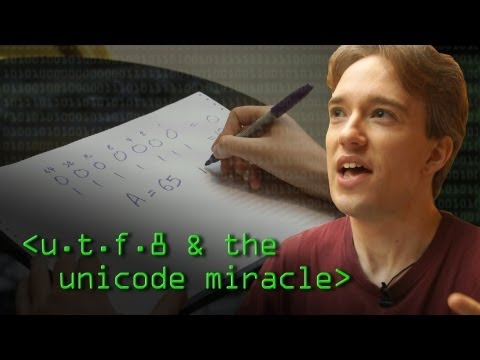

In [2]:
YouTubeVideo("MijmeoH9LT4", width=853, height=480) # Numberphile: Characters, Symbols and the Unicode Miracle - Computerphile

---

### 11.2.1 Text standardization

- Convert to **lower case**;  
- Remove **punctuation**; 
- Convert **special characters** to a standard form (é → e);
- *Stemming*: turn **inflected forms** into base ones ("stares"/"stared"/"staring" → "[stare]") 

In [3]:
s = "I didn't wake up this morning. How did that happen?"

In [4]:
s.lower()

"i didn't wake up this morning. how did that happen?"

In [5]:
"".join(char for char in s.lower() if char not in string.punctuation) # removing punctuation

'i didnt wake up this morning how did that happen'

In [6]:
def str_to_ints(s):
    s_enc = s.encode()
    print(f"{s} | {s_enc} | {list(s_enc)}") # encode into bytes, then turn into a list
s = "Jérémie"
str_to_ints(s)
str_to_ints(s.lower())
str_to_ints(unidecode.unidecode(s.lower())) # removing anything 

Jérémie | b'J\xc3\xa9r\xc3\xa9mie' | [74, 195, 169, 114, 195, 169, 109, 105, 101]
jérémie | b'j\xc3\xa9r\xc3\xa9mie' | [106, 195, 169, 114, 195, 169, 109, 105, 101]
jeremie | b'jeremie' | [106, 101, 114, 101, 109, 105, 101]


---

### 11.2.2 Text splitting (tokenization)

- **word-level tokenization**: split on spaces;
- **n-gram tokenization**: same as above, but making groups of length n;
- **character-level tokenization**: split on characters;
- **byte-level tokenization**: split on bytes.

These (except perhaps the last one) are forms of feature engineering, especially if combined with standardisation.

**Note**: algorithms such as [*byte-pair encoding*](https://huggingface.co/course/chapter6/5?fw=pt) (BPE) or [WordPiece](https://huggingface.co/course/chapter6/6?fw=pt) combine the best of both worlds by processing a corpus at the byte level, and gradually merging frequent co-occurrences, parts of words, all the way up to whole words or even phrases.

In [7]:
s = "the quick brown fox jumps over the lazy dog"
s_split = s.split(" ")
print(s)
print(s_split)

the quick brown fox jumps over the lazy dog
['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [8]:
def n_grams(l, n=2):
    n_grams = []
    for i in range(0, len(s_split) - n + 1):
        n_grams.append(s_split[i:i+n])
    return n_grams

In [9]:
n_grams(s_split, n=2) # each token is two words

[['the', 'quick'],
 ['quick', 'brown'],
 ['brown', 'fox'],
 ['fox', 'jumps'],
 ['jumps', 'over'],
 ['over', 'the'],
 ['the', 'lazy'],
 ['lazy', 'dog']]

In [10]:
n_grams(s_split, n=3) # each token is three words

[['the', 'quick', 'brown'],
 ['quick', 'brown', 'fox'],
 ['brown', 'fox', 'jumps'],
 ['fox', 'jumps', 'over'],
 ['jumps', 'over', 'the'],
 ['over', 'the', 'lazy'],
 ['the', 'lazy', 'dog']]

---

### 11.2.3 Vocabulary indexing

From a dataset, we create a big table **associating each word with a number**.

We can also add special information like an index for:
- **unknown words** ("\[UNK\]" for *unknown*, aka OOV: out of vocabulary);
- **beginning of sentence** ("bos"); 
- **end of sentence** ("eos");
- **padding** ("\[PAD\]", to make sequences the same length);
- **masked token**, and other customised "special tokens" depending on needs...

In [11]:
vocab = {token:i for i,token in enumerate(sorted(list(set(s_split))))}
vocab

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

In [12]:
print([vocab[word] for word in s_split])

[7, 6, 0, 2, 3, 5, 7, 4, 1]


In [13]:
print([vocab[word] for word in "the quick fox".split(" ")])

[7, 6, 2]


<!-- <img style="height: 750px" src="images/nlp/chollet.from-raw-to-vectors.png"> -->
<img style="height: 700px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/nlp/chollet.from-raw-to-vectors.png?raw=true">
<small>DLWP, p.312</small>

In [14]:
class Vectorizer:
    """
    An implementation of the transformations in the above schema.
    """
    def standardize(self, text):
        """Make lowercase and remove punctuation"""
        text = text.lower()                                # Python built-in list of punctuation characters
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        """Standardize then split on space"""
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        """Generate token vocabulary from text"""
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            tokens = self.tokenize(text) # this will standardize
            for token in tokens:                                  # first element will be 2
                if token not in self.vocabulary:                  # then len(vocab) is 3 →
                    self.vocabulary[token] = len(self.vocabulary) # next token is 3, etc.
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        """Encode string to tokens"""
        tokens = self.tokenize(text) # this will standardize
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        """Decode tokens to string"""        
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

    def one_hot_encode(self, encoded_sequence):
        vector = np.zeros((len(encoded_sequence), len(self.vocabulary)))
        for i, token in enumerate(encoded_sequence):
            vector[i, token] = 1
        return vector
    
    def one_hot_decode(self, one_hot_sequence):
        return list(np.where(one_hot_sequence == 1)[1])

In [15]:
vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [16]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [17]:
one_hot_sentence = vectorizer.one_hot_encode(encoded_sentence)
print(one_hot_sentence)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [18]:
encoded_sentence = vectorizer.one_hot_decode(one_hot_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [19]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


---

### 11.2.4 Using the TextVectorization layer

Documentation for [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [20]:
text_vectorization = tf.keras.layers.TextVectorization(
    output_mode="int" # returns a sequence of integers
) 

A lot of options available in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [21]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]                # ↓ the `adapt()` method is the equivalent to the `fit()` one for models
text_vectorization.adapt(dataset)

In [22]:
vocabulary = text_vectorization.get_vocabulary()
print(vocabulary) # displaying the vocabulary

['', '[UNK]', 'erase', 'write', 'then', 'rewrite', 'poppy', 'i', 'blooms', 'and', 'again', 'a']


In [23]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [24]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence) # 'still' was not present in the original corpus (our three sentences)

i write rewrite and [UNK] rewrite again


#### Note

How do you customize such a layer? You can pass user-defined functions to it.

(Documentation for the [`tf.strings`](https://www.tensorflow.org/api_docs/python/tf/strings) module)  
(Regular expressions are *very* useful for any text manipulation: tutorials [here](https://realpython.com/regex-python/), [here](https://realpython.com/regex-python-part-2/) and [here](https://docs.python.org/3/howto/regex.html))

In [26]:
def custom_standardization_fn(string_tensor):
    """Standardize string tensor using regex (REGular EXpressions)"""
    lowercase_string = tf.strings.lower(string_tensor)               # to lower case
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", ""   # remove all punctuation
    )

def custom_split_fn(string_tensor):
    """Split string tensor"""
    return tf.strings.split(string_tensor)                           # split on spaces

text_vectorization = tf.keras.layers.TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn, # apply special functions to
    split=custom_split_fn,                 # standardize and split
)

---

## 11.3 Two approaches for representing groups of words: Sets and sequences

- Sets: "bag of words", the order is lost.  
- Sequences: order/time matters!

### 11.3.1 Preparing the IMDB movie reviews data

### Downloading the data

Commands to download and uncompress the imdb dataset:

```bash
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz # this untars the archive to a folder called aclImdb
!rm aclImdb_v1.tar.gz      # remove the downloaded archive
!rm -r aclImdb/train/unsup # unsupervised data not needed
```

#### Reminder

In Colab, use a bang (!) to run a bash command. You can also run them in a terminal (without the initial !).

#### Other reminders

- You can use symlinks in Linux to avoid downloading things twice!

    ```bash
    # will create a folder called 'dataset' in the current dir, linked to the other one
    !ln -s /path/to/already/downloaded/dataset 
    ```
     
- In Google drive, the same can be achieved by selecting the directory you want to link to, and pressing Shift+Z, then selecting the target directory.

In [27]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [28]:
# code to split the data into train/val folders
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"
for category in ("neg", "pos"):
    if not os.path.isdir(val_dir / category):    # do this only once
        os.makedirs(val_dir / category)          # make 'neg'/'pos' dir in validation
        files = os.listdir(train_dir / category) # list files in 'train'
        random.Random(1337).shuffle(files)       # shuffle using a seed
        num_val_samples = int(0.2 * len(files))  # 2% of our samples for validation
        val_files = files[-num_val_samples:]
        for fname in val_files:                  # move our files
            shutil.move(train_dir / category / fname,
                        val_dir / category / fname)

In [29]:
batch_size = 32

# Keras helper functions creating Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# The documentation:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory

# each of these iterables returns tuples containing two tensors:
# samples, shape: (batch_size, sample_shape) ← our texts
# targets, shape: (batch_size,)              ← 0 or 1
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    val_dir, batch_size=batch_size
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [30]:
for inputs, targets in train_ds:            # displaying the shapes and dtypes of the first batch
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print()
    print("targets[0]:", targets[0].numpy())
    print()
    print("inputs[0]:", inputs[0].numpy())
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>

targets[0]: 1

inputs[0]: b'Although the beginning of the movie in New York takes too long, the movie is a must see for people who like this genre. When Hannah goes to Berlin to visit the older woman who helped her mother during the war, the movie gets much much better.The movie is a bit like The Pianist, can not really be compared.'


---

### 11.3.2 Processing words as a set: The bag-of-words approach

### Single words (unigrams) with binary encoding

- unigram: first you split, then take each split on its own
- binary encoding: multi-hot
- the order is lost

In [31]:
set("the cat sat on the mat".split()) # unigram == bag of words (BOW)

{'cat', 'mat', 'on', 'sat', 'the'}

In [32]:
text_vectorization = tf.keras.layers.TextVectorization( # preprocessing our datasets with a `TextVectorization` layer
    max_tokens=20000,                                   # cap the vocab size to 20k
    output_mode="multi_hot",                            # a 1 at the index of each word present, 0 otherwise
)

In [33]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [34]:
vocabulary = text_vectorization.get_vocabulary()
inverse_vocab = dict(enumerate(vocabulary))

In [35]:
cat = text_vectorization("the cat")
print(cat.numpy(), cat.shape)                                    # "the cat" is now a vector of 20000 zeros
                                                                 #  with 1s at the index of "the" and "cat"
print()
indz = tf.where(cat > 0)                                         # retrieving the indices of the words
print(indz.numpy())
print()
print(" ".join([inverse_vocab[i.numpy().item()] for i in indz])) # retranslating back into a string

[0. 1. 0. ... 0. 0. 0.] (20000,)

[[   1]
 [1150]]

the cat


In [36]:
cat = text_vectorization("the cute cat")
print(cat.numpy(), cat.shape)
print()
indz = tf.where(cat > 0)
print(indz.numpy())
print()
print(" ".join([inverse_vocab[i.numpy().item()] for i in indz]))

[0. 1. 0. ... 0. 0. 0.] (20000,)

[[   1]
 [1020]
 [1150]]

the cute cat


---

### Training a simple model with unigrams

In [37]:
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

In [38]:
for inputs, targets in binary_1gram_train_ds: # inspecting the output of our binary unigram dataset
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print()
    print("targets[0]:", targets[0].numpy())
    print()
    print("inputs[0]:", inputs[0].numpy())
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>

targets[0]: 1

inputs[0]: [1. 1. 1. ... 0. 0. 0.]


In [39]:
def get_model(max_tokens=20000, hidden_dim=16, clear=True):
    """
    Our model-building utility
    """
    if clear:
        tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy", # our labels are only 0 or 1 (negative/positive)
        metrics=["accuracy"]
    )
    return model

In [40]:
# Training the binary unigram model
model = get_model()
model.summary()

callbacks = [ # using a callback to save our model
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "binary_1gram.h5"), # NOTE: in DLWP, he uses the current `.keras` format, but ModelCheckpoint
        save_best_only=True                # in TF 2.13 now breaks when using it with `save_best_only`...
    )                                      # see: https://github.com/keras-team/tf-keras/issues/151
]

model.fit(
    binary_1gram_train_ds.cache(),
    validation_data=binary_1gram_val_ds.cache(),
    epochs=10,
    callbacks=callbacks
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 14s 13ms/step - loss: 0.4287 - accuracy: 0.8171 - val_loss: 0.2987 - val_accuracy: 0.8774


/home/jcw/anaconda3/envs/gold/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2914 - accuracy: 0.8934 - val_loss: 0.2787 - val_accuracy: 0.8846
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2599 - accuracy: 0.9074 - val_loss: 0.2773 - val_accuracy: 0.8906
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2406 - accuracy: 0.9147 - val_loss: 0.2926 - val_accuracy: 0.8880
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2264 - accuracy: 0.9219 - val_loss: 0.2977 - val_accuracy: 0.8946
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2261 - accuracy: 0.9227 - val_loss: 0.3167 - val_accuracy: 0.8854
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2234 - accuracy: 0.9268 - val_loss: 0.3239 - val_accuracy: 0.8826
Epoch 8/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2133 - accuracy: 0.9311 - val_loss: 0.3366 - val_accuracy: 0.8846
Epoch

In [41]:
# And testing it
model = tf.keras.models.load_model(base_dir / "binary_1gram.h5")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds, verbose=0)[1]:.3f}")
del model

Test acc: 0.880


----

### Bigrams with binary encoding


- bigram: first you split, then take tokens two by two   
- binary encoding: multi-hot (each bigram is one token!)
- *almost all* order is lost

In [42]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2, # ← returns bigrams
    max_tokens=20000, output_mode="multi_hot",
)

In [43]:
text_vectorization.adapt(["I write, erase, rewrite","Erase again, and then","A poppy blooms.",])
vocabulary = text_vectorization.get_vocabulary()
print(f"{len(vocabulary)} tokens: {vocabulary}") # displaying the vocabulary

19 tokens: ['[UNK]', 'erase', 'write erase', 'write', 'then', 'rewrite', 'poppy blooms', 'poppy', 'i write', 'i', 'erase rewrite', 'erase again', 'blooms', 'and then', 'and', 'again and', 'again', 'a poppy', 'a']


In [44]:
encoded_sentence = text_vectorization("I write, rewrite, and still rewrite again")
print(encoded_sentence)

tf.Tensor([1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.], shape=(19,), dtype=float32)


---

### Training a simple model with bigrams

In [46]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2, # ← returns bigrams
    max_tokens=20000, output_mode="multi_hot",
)

text_vectorization.adapt(text_only_train_ds)

# prepare our datasets
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [47]:
# Training the binary bigram model
model = get_model()
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "binary_2gram.h5"),
        save_best_only=True
    )
]

model.fit(
    binary_2gram_train_ds.cache(),
    validation_data=binary_2gram_val_ds.cache(),
    epochs=10,
    callbacks=callbacks
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 13ms/step - loss: 0.3888 - accuracy: 0.8348 - val_loss: 0.2524 - val_accuracy: 0.9042
Epoch 2/10
62

In [50]:
#  and testing 
model = tf.keras.models.load_model(base_dir / "binary_2gram.h5")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds, verbose=0)[1]:.3f}") # better than the unigram model
del model

Test acc: 0.897


---

### Bigrams with TF-IDF encoding

Chollet mentions one more technique in the chapter:  
**TF-IDF: Term Frequency / Inverse Document Frequency**  
The aim of this technique is to count the frequency of words but also prevent very common words (syntactic words, or *stop words*, like "the" or "a") from being too important.

Check out [this notebook](https://github.com/jchwenger/AI/blob/main/6-additional-material/chapter11_part01_introduction_tfidf.ipynb) if you want to learn more about it.


```python
tf.keras.layers.TextVectorization(
    ngrams=2,          # number n in n-grams
    max_tokens=20000,  # size of the vocabulary
    standardize=None,  # "lower_and_strip_punctuation", "lower",
                       # "strip_punctuation", or a callable
    split=None,        # "whitespace", "character" for unicode, or a callable
    output_mode="int", # "int": one-hot, "multi_hot", 
                       # "count": multi-hot & counting, "tf_idf"
    # more options!
)
```

Documentation for [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

---

#### Note (functional syntax for usability)

How to define a model that takes strings (rather than encoded sequences of tokens) as an input?

```python
inputs = tf.keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)     # functional syntax:
outputs = model(processed_inputs)                 # plugging an existing model
inference_model = tf.keras.Model(inputs, outputs) # into a new one
```
```python
raw_text_data = tf.convert_to_tensor([            # to use our model, we still  
    ["That was an excellent movie, I loved it."], # convert our string to a
])                                                # string tensor
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")
```

## Summary

### NLP

- **standardisation** / **tokenisation** / **indexing**
- tokenisation: various possible **levels** (words, characters, n-grams, etc.)

- **Two kinds of NLP models**:
  - **bag-of-words** sets of words or n-grams, the order is lost.
  - **sequence models** that process word order.

See also [Huggingface's NLP course](https://huggingface.co/learn/nlp-course/chapter1/1)